Here, we want to know the model with the best explanatory power.

## Requirements

```bash

conda create -n otka_bambi
conda activate otka_bambi
conda install python ipykernel
pip install watermark bambi==0.9.0 xarray netcdf4 seaborn
# pip install bokeh
```

In [1]:
import arviz as az
import bambi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr

In [2]:
grid_results = pd.read_csv('data/classification_results/grid_results.csv', index_col=0)

grid_results['label'] = grid_results['param_extract__kind'] + ' (' + grid_results['param_extract__frequency_band'] + ')'

# Sift out the best params (C and feature selections) for each model
idx = grid_results.groupby('label')['mean_test_score'].transform(max) == grid_results['mean_test_score']
grid_results = grid_results[idx]
grid_results.drop_duplicates(subset='label', inplace=True)

split_cols = [c for c in grid_results.columns if 'split' in c]

grid_results['test_score'] = grid_results[split_cols].apply(lambda x: list(x), axis=1)
grid_results.drop(columns=split_cols, inplace=True)
grid_results = grid_results.explode('test_score')

grid_results = grid_results[['param_extract__frequency_band', 'param_extract__kind', 'test_score']]
grid_results.rename(columns={'param_extract__frequency_band': 'band',
                       'param_extract__kind': 'kind'},
                        inplace=True)
grid_results[['input_type', 'source']] = grid_results['kind'].apply(lambda x: x.split(' ')).apply(pd.Series)
grid_results['source'] = grid_results['source'].apply(lambda x: x.replace('source', 'region'))

grid_results['source'] = grid_results['source'].astype('category')
grid_results['input_type'] = grid_results['input_type'].astype('category')
grid_results['band'] = grid_results['band'].astype('category')
grid_results.drop(columns='kind', inplace=True) # drop to prevent confusion

grid_results.reset_index(drop=True, inplace=True)
new_cols = ['band', 'accuracy', 'method', 'signal_type']
grid_results.columns = new_cols
grid_results.accuracy = grid_results.accuracy.astype('float')

In [ ]:
model = bambi.Model('accuracy ~ band * method * signal_type', grid_results)
fitted = model.fit(tune=500, draws=2000, chains=2)

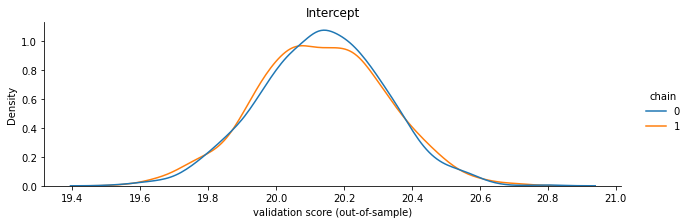

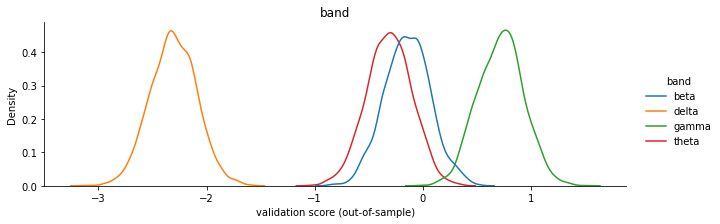

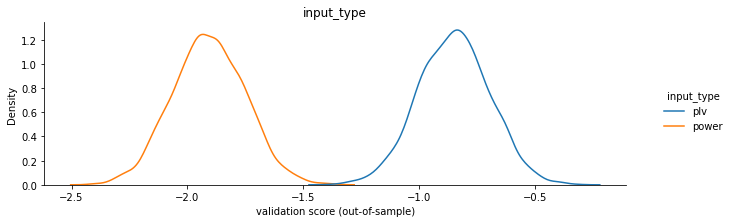

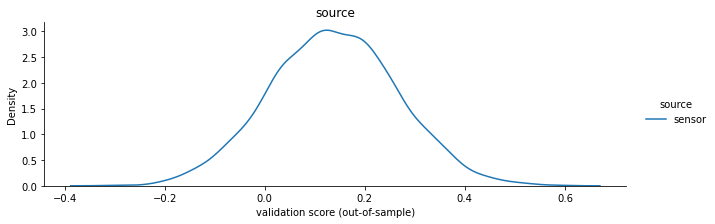

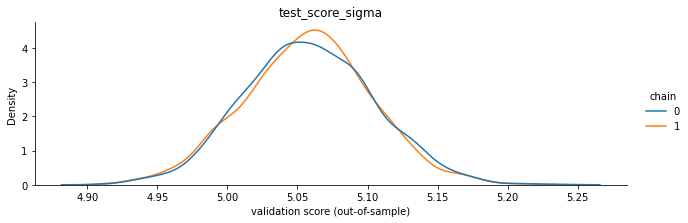

In [ ]:
for i, var_name in enumerate(fitted['posterior'].data_vars):
    plot_data = fitted['posterior'][var_name].to_dataframe().reset_index()
    hue_dim = 0 if 'test_score_sigma' in var_name or 'Intercept' in var_name else 2
    g = sns.displot(data=plot_data,
                    x=var_name,
                    kind='kde',
                    aspect=3,
                    height=3,
                    hue=fitted['posterior'][var_name].dims[hue_dim],
                    # height=2, aspect=2,
                    )
    g.set(xlabel='validation score (out-of-sample)')
    g.set(title=var_name)
    g.legend.set_title(g.legend.get_title().get_text().replace('_dim',''))

    plt.show()


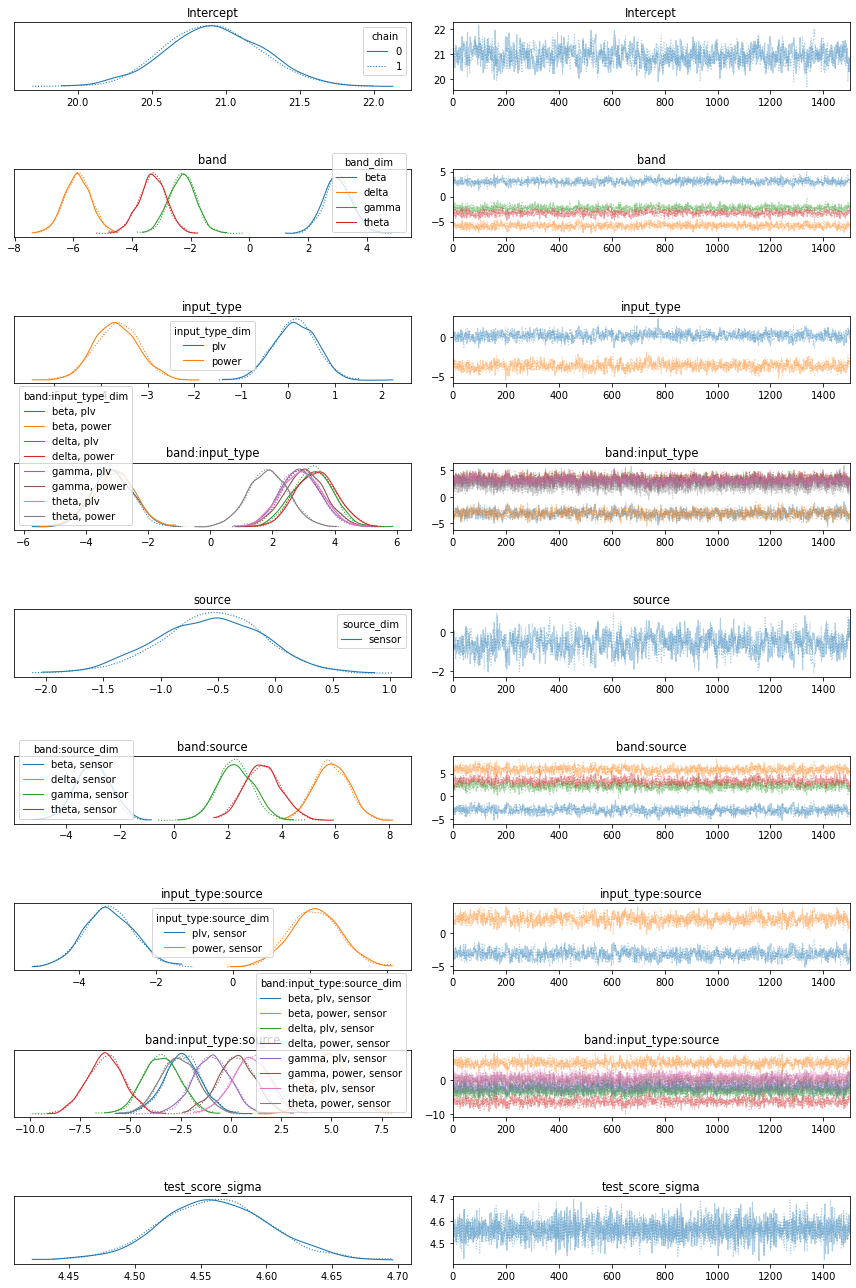

In [ ]:
az.plot_trace(fitted, legend=True)

plt.tight_layout()
plt.show()

In [ ]:
# # save InferenceData
from pathlib import Path
path = Path('data/inference_data/')
# fitted.to_netcdf(path/'model_with_interaction_2.nc')

# load InferenceData
fitted = az.from_netcdf(path/'model_without_interaction.nc')

In [ ]:
# compare models
model_dict = {'with_interaction': fitted,
              'without_interaction': fitted2}

az.compare(model_dict)

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
with_interaction,0,-17634.141226,30.885100,0.000000,1.0,55.392573,0.000000,False,log
without_interaction,1,-18244.424749,8.950419,610.283522,0.0,55.262206,35.076077,False,log


## Grid search with nested CV results

In [2]:
# nested grid results
grid_results = pd.read_csv('data/classification_results/nested_grid_results_without_hp_tuning.csv',
                           index_col=0)
# remove plv results
col = [i for i in grid_results.columns if 'plv' in i]
grid_results.drop(columns=col, inplace=True)

grid_results = grid_results.melt()
grid_results[['method', 'signal_type', 'band']] = grid_results['variable'].apply(lambda x:x.split(' ')).apply(pd.Series)
grid_results = grid_results.drop('variable', axis=1).rename({'value':'accuracy'}, axis=1)
grid_results['band']= grid_results['band'].apply(lambda x:x[1:-1])

In [4]:
model = bambi.Model('accuracy ~ band * method * signal_type', grid_results)
fitted = model.fit(tune=350, draws=1500, chains=2)
# fitted.to_netcdf('models/bayesian/nested_nohp_nointeraction_withplv.nc')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [Intercept, band, method, band:method, signal_type, band:signal_type, method:signal_type, band:method:signal_type, accuracy_sigma]


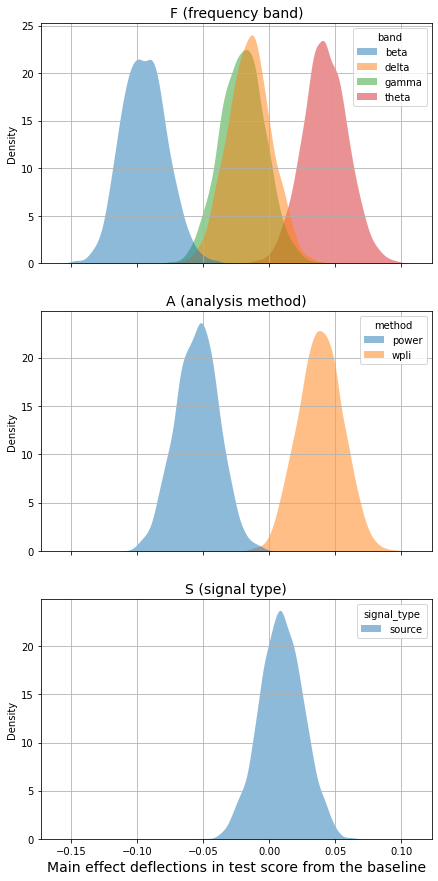

In [5]:
## read inference data and visualize posterior distributions
fitted = az.from_netcdf('models/bayesian/nested_nohp_1500draws.nc')
# fitted2 = az.InferenceData.from_netcdf('models/bayesian/nested_nohp.nc')

fig, axes = plt.subplots(3, 1, figsize=(7, 5*3), sharex=True)
for i, var_name in enumerate(['band', 'method', 'signal_type']):
  plot_df = fitted['posterior'][var_name].to_dataframe().reset_index()
  g = sns.kdeplot(data=plot_df,
                  x=var_name,
                  hue=f'{var_name}_dim',
                  fill=True,
                  common_norm=False,
                  # palette="crest",
                  alpha=.5,
                  linewidth=0,
                  ax=axes[i],
                  )
  
  if var_name == 'band':
    title = 'F (frequency band)'
  elif var_name == 'method':
    title = 'A (analysis method)'
  else:
    title = 'S (signal type)'
    var_name = var_name.split('_')[0] + ' ' + var_name.split('_')[1]
    
  g.set(xlabel='')
  g.set_title(title, size=14)
  g.grid()
  g.legend_.set_title(g.legend_.get_title().get_text().replace('_dim',''))
plt.xlabel(f'Main effect deflections in test score from the baseline', fontsize=14)
plt.show()